In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

from datetime import datetime, timedelta

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def add_date_time(df):
    dts = []
    for idx in df.index:
        dts.append( datetime(
            df.loc[idx, 'year'],
            df.loc[idx, 'month'],
            df.loc[idx, 'day'],
            df.loc[idx, 'hour']-1, 
            0 # minutes
        ))
    df['date_time'] = dts
    return df

In [3]:
demands = {
    'ERCOT' : ['../data/ERCOT_mem_1998-2019.csv', 0, 2003],
    'PJM' : ['../data/PJM_mem_1993-2019.csv', 0, 2006],
    'NYISO' : ['../data/NYISO_demand_unnormalized.csv', 0, 2004],
    'France' : ['../data/FR_demand_unnormalized.csv', 0, 2008],
}

dfs = {}
for k, v in demands.items():
    print(k, v)
    df = pd.read_csv(v[0], header=v[1])
    print(len(df.index))
    df = df[ (df['year'] >= v[2]) & (df['year'] <= 2019) ]
    df = df.reset_index()
    df = add_date_time(df)
    print(len(df.index))
    dfs[k] = df.reset_index()
    print(dfs[k].head())
    print(dfs[k].tail())

ERCOT ['../data/ERCOT_mem_1998-2019.csv', 0, 2003]
184080
149016
   level_0  index  year  month  day  hour   demand (MW)           date_time
0        0  35058  2003      1    1     1  29972.838668 2003-01-01 00:00:00
1        1  35059  2003      1    1     2  29506.685679 2003-01-01 01:00:00
2        2  35060  2003      1    1     3  28652.014481 2003-01-01 02:00:00
3        3  35061  2003      1    1     4  27832.198579 2003-01-01 03:00:00
4        4  35062  2003      1    1     5  27068.465106 2003-01-01 04:00:00
        level_0   index  year  month  day  hour   demand (MW)  \
149011   149011  184069  2019     12   31    20  38694.698238   
149012   149012  184070  2019     12   31    21  38030.317245   
149013   149013  184071  2019     12   31    22  37668.155054   
149014   149014  184072  2019     12   31    23  38114.822606   
149015   149015  184073  2019     12   31    24  40216.534912   

                 date_time  
149011 2019-12-31 19:00:00  
149012 2019-12-31 20:00:00  
1

0 PJM
Y = 79663.38634698896 * e^(-1.286079570575627e-06 * x)
Exp: 1 year growth 1.12%
1 ERCOT
Y = 32022.06128135009 * e^(-2.016382912456716e-06 * x)
Exp: 1 year growth 1.751%
2 NYISO
Y = 18849.369359488286 * e^(--2.918720384520741e-07 * x)
Exp: 1 year growth -0.256%
3 France
Y = 56769.14591102583 * e^(--6.277503675418451e-07 * x)
Exp: 1 year growth -0.551%

0 PJM
Y = 79663.38634698896 * e^(-1.286079570575627e-06 * x)
Exp: 1 year growth 1.12%
1 ERCOT
Y = 32022.06128135009 * e^(-2.016382912456716e-06 * x)
Exp: 1 year growth 1.751%
2 NYISO
Y = 18849.369359488286 * e^(--2.918720384520741e-07 * x)
Exp: 1 year growth -0.256%
3 France
Y = 56769.14591102583 * e^(--6.277503675418451e-07 * x)
Exp: 1 year growth -0.551%
_LONG


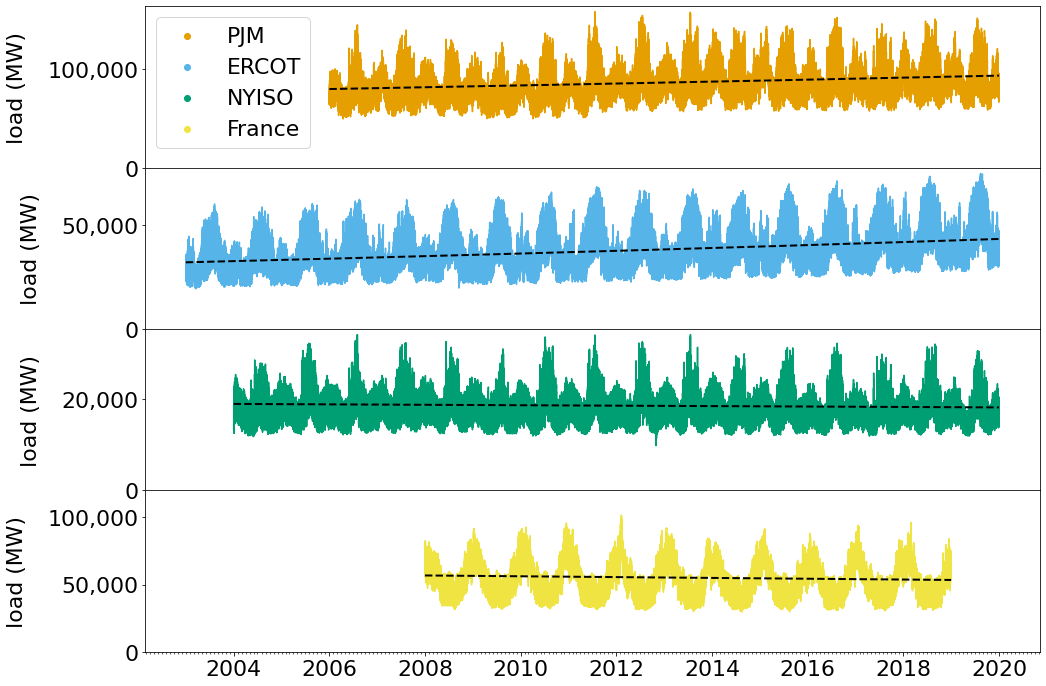

In [4]:
# Based on common color blindness
# https://www.nature.com/articles/nmeth.1618/figures/2
# Skip black and reserve it for other specific lines
def color_list():
    l = [
            np.array([230, 159, 0]), # orange
            np.array([86, 180, 233]), # Sky blue
            np.array([0, 158, 115]), # Bluish green
            np.array([240, 228, 66]), # Yellow
            np.array([0, 114, 178]), # Blue
            np.array([213, 94, 0]), # Vermillion
            np.array([204, 121, 167]), # Reddish purple
    ]
    return [i/255. for i in l]

def fit(k, v):
    matplotlib.rcParams.update({'font.size': 20})
    plt.close()
    fix, ax = plt.subplots(figsize=(15,5))
    print(k)#, v)
    x = v.index
    y = v['demand (MW)']
    dt = v['date_time']
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
    print(coef)
    print(f"Delta 1 year: {coef[0]*8760}")
    print(f"Delta 1 year as % yr 1: {coef[0]*8760/coef[1]}")
    
    ax.plot(dt,y, 'y.')
    ax.plot(dt, poly1d_fn(x), '--k')
    
    ax.set_ylabel('load (MW)')
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=45 )
    
    ax.set_ylim(0, ax.get_ylim()[1])
    plt.tight_layout()
    plt.savefig(f'raw_demand_{k}.pdf')
    plt.savefig(f'raw_demand_{k}.png')

def monoExp(x, m, t):
    return m * np.exp(t * x)
    
def exp_growth(df):
    xs = df.index
    ys = df['demand (MW)']
    # perform the fit
    p0 = np.array([np.mean(ys), 0.000001]) # start with values near those we expect
    params, cv = curve_fit(monoExp, xs, ys, p0)
    m, t = params
    
    # inspect the parameters
    print(f"Y = {m} * e^(-{t} * x)")
    print(f"Exp: 1 year growth {round((1. - monoExp(0, m, t)/monoExp(8760, m, t))*100.,3)}%")
    
    return m, t

def fit_all(dfs, LONG=False):
    matplotlib.rcParams.update({'font.size': 22})
    plt.close()
    fix, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,10), sharex=True)
    
    colors = color_list()
    i = 0
    for k, ax in zip(["PJM", "ERCOT", "NYISO", "France"], axs):
        print(i, k)
        x = dfs[k].index
        y = dfs[k]['demand (MW)']
        dt = dfs[k]['date_time']
        
        year_min = 2008 if k == 'France' else 2010
        year_max = 2017 if k == 'France' else 2019
        df = dfs[k]
        if not LONG:
            df = df.loc[ (df['year'] >= year_min) & (df['year'] <= year_max) ]
        x2 = df.index
        y2 = df['demand (MW)']
        dt2 = df['date_time']
        #steps = make_mean_step_functions(dfs[k])
        #coef = np.polyfit(x, y, 1)
        #poly1d_fn = np.poly1d(coef) 
        # poly1d_fn is now a function which takes in x and returns an estimate for y
        #print(coef)
        #print(f"Delta 1 year as % yr 1: {coef[0]*8760/coef[1]*100.}")

    
        ax.plot(dt2,y2, color=colors[i], label='_nolabel_')
        #ax.plot(dt, poly1d_fn(x), '--k', label='_nolabel_')
        #ax.plot(dt, steps, '--k', linewidth=3, label='_nolabel_')
        exp_m, exp_t = exp_growth(dfs[k])
        ax.plot(dt2, monoExp(x2, exp_m, exp_t), '--k', linewidth=2, label="_nolabel_")
        if k == 'France':
            ax.set_ylim(0, 120000)
    
        if i == 2:
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
        
        ax.set_ylabel('load (MW)', labelpad=20)
        ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
        ax.set_ylim(0, ax.get_ylim()[1])
        if i == 0:
            j = 0
            for k in ["PJM", "ERCOT", "NYISO", "France"]:
                axs[0].scatter([], [], color=colors[j], marker='o', label=k)
                j += 1
        i += 1
    
   
    axs[0].legend(loc='upper left')
    
    plt.setp( axs[2].xaxis.get_majorticklabels(), rotation=45 )
    plt.tight_layout()
    plt.subplots_adjust(hspace = 0.0)
    #plt.savefig('raw_demand_ALL.pdf')
    app = '_LONG' if LONG else ''
    print(app)
    plt.savefig(f'raw_demand_ALL{app}.png')

    
def make_mean_step_functions(df):
    years = np.arange(df.iloc[0]['date_time'].year, df.iloc[-1]['date_time'].year+1)
    print(years)
    steps = []
    for yr in years:
        l = (df['year'] == yr).sum()
        m = np.mean(df.loc[df['year'] == yr, 'demand (MW)'])
        #print(yr, m)
        for i in range(l):
            steps.append(m)
    return steps
#for k, v in dfs.items():
#    print(f"\n\n{k}")
#    fit(k, v)
    
#    print(f"Mean 2019 demand: {np.mean(v.loc[ (v['year']==2019), 'demand (MW)'])}")

fit_all(dfs)
LONG = True
fit_all(dfs, LONG)